# 概要
鍵ステータス情報の異常値検出がメインタスク．  
ここでは，$k$-means法により鍵ステータス情報をクラスタリングする．

## KDD Cup 1999(SMTP)のデータセットを用いたテスト
### 実装

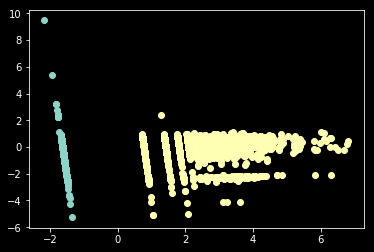

9568
3


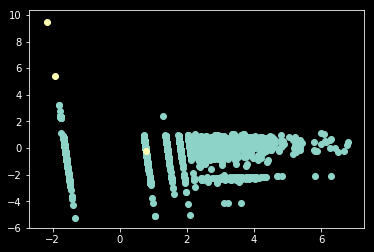

In [110]:
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_kddcup99
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# change plt style
plt.style.use("dark_background")

# load datasets
kdd_datasets = fetch_kddcup99(subset="smtp")
# dim reduction by PCA
pca = PCA(n_components=2)
X = pca.fit_transform(kdd_datasets.data)

# define cluster and calc cluster center
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

# clustering datasets
C = [[], []]
for x_part in X:
    x_part = x_part.reshape((1, x_part.shape[0]))
    C[kmeans.predict(x_part)[0]].append(x_part.tolist()[0])

# plot predict data
for c_part in C:
    if len(c_part) > 0:
        c_x, c_y = zip(*c_part)
        plt.scatter(c_x, c_y)

plt.legend()
plt.show()

# plot answer data
C_ans = [[normal_data for i, normal_data in enumerate(X) if kdd_datasets.target[i] == b'normal.'],
         [normal_data for i, normal_data in enumerate(X) if kdd_datasets.target[i] != b'normal.']]
for c_part in C_ans:
    print(len(c_part))
    if len(c_part) > 0:
        c_x, c_y = zip(*c_part)
        plt.scatter(c_x, c_y)

plt.legend()
plt.show()

### ここまでの考察
$k$-meansでは異常値を適切にクラスタリングできないように思う．  
異常値がクラスタとして十分な個数まとまって存在する必要がある．

## 鍵情報を用いたテスト

### 方針
ON/OFFをひとつのデータセットとして取り扱うと，ON/OFFでのクラスタリングがされると想定できる．  
ON/OFFそれぞれでクラスタリングすることを考える．

特徴量を下記に設定する．  
* イベント month
* イベント day
* イベント week
* イベント hour

### 実装

#### データ加工

In [89]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# const val
ISO_DATE_LEN = 24

# change plt style
plt.style.use("dark_background")

# load datasets
df = pd.read_csv("./key_info_20181102_anomaly.csv")
# convert str(ISO 8601 format) to datetime and convert timezone UTC to Asia/Tokyo
df["time"] = df["time"].str.ljust(ISO_DATE_LEN, "0")
df["time"] = pd.to_datetime(df["time"]).dt.tz_localize(tz="UTC").dt.tz_convert(tz="Asia/Tokyo")

# make column
df["month"] = df["time"].dt.month
df["day"] = df["time"].dt.day
df["week"] = df["time"].dt.weekday
df["hour"] = df["time"].dt.hour

# to ndarray
X_on = df[df["state"].str.match("ON")][["month", "day", "week", "hour"]].values
y_on = df[df["state"].str.match("ON")][["is_anomal"]].values
X_off = df[df["state"].str.match("OFF")][["month", "day", "week", "hour"]].values
y_off = df[df["state"].str.match("OFF")][["is_anomal"]].values

#### クラスタリング
ただし，可視化のためそれぞれの次元でプロットしてみる

51
38


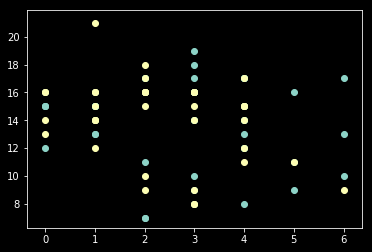

81
8


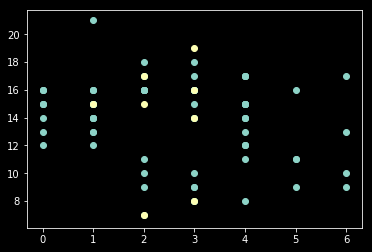

In [111]:
# define cluster and calc cluster center
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_on)

# clustering datasets
C = [[], []]
for x_part in X_on:
    x_part = x_part.reshape((1, x_part.shape[0]))
    C[kmeans.predict(x_part)[0]].append(x_part[0])

# plot predict data
for c_part in C:
    print(len(c_part))
    if len(c_part) > 0:
        c_part = np.asarray(c_part)
        c_x, c_y = c_part[:, 2], c_part[:, 3]
        plt.scatter(c_x, c_y)
        
plt.legend()
plt.show()

# plot answer data
X_on_part = X_on[:, 2:4]
C_ans = [[normal_data for i, normal_data in enumerate(X_on_part) if bool(y_on[i]) == False],
         [normal_data for i, normal_data in enumerate(X_on_part) if bool(y_on[i]) == True]]
for c_part in C_ans:
    print(len(c_part))
    if len(c_part) > 0:
        c_x, c_y = zip(*c_part)
        plt.scatter(c_x, c_y)

plt.legend()
plt.show()

### 考察
クラスタリングしたとして，どちらのクラスが異常値であるか見極めることが難しい．  
例えば，is_anomalの正解データからクラスを推定することが考えられる．  
非アノテートで仮定を置くとすれば，要素数の少ないクラスタを異常として置くことが考えられる．

* クラスタのそれぞれのデータセット数: 51, 38
* ノーマル, アノーマルのそれぞれのデータセット数: 81, 8

クラスタはアノーマルとノーマルにクラスタリングされているとは言えない．  
これは，各クラスタに属するデータ数の比から明らか．